In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateutil
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from wavelet import wavelet
from wave_signif import wave_signif
from wavelet_inverse import wavelet_inverse

In [24]:
#-----------------------------------------------------------------------------
def wavelet_spectrum(file):
    
    s_year = '2012-01-01 00:00'    
    e_year = '2016-12-31 23:00' 
    
    lists = pd.read_csv(file)
    
    lists['obstime'] = lists['obstime'].apply(dateutil.parser.parse)   
    
    
    # sorting data and dropping duplicate values 
    lists.sort_values("obstime", inplace=True)
    lists.drop_duplicates(keep=False,inplace=True)
    
    lists = lists.set_index(lists['obstime'])

    lists = lists.loc[s_year:e_year]
    
    datas = lists['tempr']
    datas = datas[datas > -273]
    
    t_data = datas.groupby(pd.Grouper(freq='D')).mean().dropna()
    print(t_data)
    sst = t_data.values
    print(sst)
    n=len(sst)
    dt = 0.25
    
    time = np.arange(n)*dt + 0.0   # construct time array
    
    variance = np.std(sst)**2

    sst = (sst - np.mean(sst))/np.sqrt(variance)
    st_d=np.sqrt(variance)
    
    pad = 1      # pad the time series with zeroes (recommended)
    dj = 0.25    # this will do 4 sub-octaves per octave
    s0 = 2.*dt    # this says start at a scale of 6 months
    j1 = 7/dj    # this says do 7 powers-of-two with dj sub-octaves each
    lag1 = 0.72  # lag-1 autocorrelation for red noise background
    mother = 'Morlet'
    
    wave,period,scale,coi = wavelet(sst,dt,pad,dj,s0,j1,mother)
    power = (np.abs(wave))**2         # compute wavelet power spectrum
    
    signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
    sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
    sig95 = power / sig95         # where ratio > 1, power is significant
    
    global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
    dof = n - scale  # the -scale corrects for padding at edges
    global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)
    
    
    avg = (scale >= 2) & (scale < 8)
    Cdelta = 0.776;   # this is for the MORLET wavelet
    scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
    scale_avg = power / scale_avg   # [Eqn(24)]
    scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
    scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)
    
    iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
    rsq_m = np.sqrt(np.sum((sst-iwave)**2)/float(len(sst)))*np.sqrt(variance)
#    print ("root square mean error",rsq_m,"deg C")
    
    #figure size
    fig=plt.figure(figsize=(12,12))
    
    # subplot positions
    width= 0.80
    height = 0.40
    pos1b = [0.1, 0.37, width, height]
    pos1d = [0.37,  0.07, 0.18, 0.2]
    
    
    #########################################
    #   a) Wavelet spectrum
    #########################################
    
    #--- Contour plot wavelet power spectrum
    bx=fig.add_axes(pos1b)
    levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16]
    Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
    bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
    bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels),extend='both', cmap=plt.cm.jet)
    bx.set_xlabel('Days \n2012-2016')
    bx.set_ylabel('Period (years)')
    
    ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
    bx.yaxis.set_major_locator( ymajorLocator )
    bx.yaxis.set_ticklabels(Yticks)
    plt.title('Wavelet Power Spectrum')
   
    # cone-of-influence, anything "below" is dubious
    ts = time;
    coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
    ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
    
    bx.plot(ts_area,np.log2(coi_area),'k',linewidth=2)
    bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3)
    bx.xaxis.set_major_formatter(NullFormatter())
    


    #########################################
    #   b) Global Wavelet spectrum
    #########################################
    
    #--- Plot global wavelet spectrum
    cx=fig.add_axes(pos1d,sharey=bx)
    cx.plot(global_ws,np.log2(period),"r-")
    cx.plot(global_signif,np.log2(period),'k--')
    cx.set_ylim(np.log2([period.min(),period.max()]))
    cx.invert_yaxis()
    cx.set_xlabel("Log\u00b2 (Power)")
    plt.title('Global Wavelet Spectrum')
    cx.set_xlim([0,1.25*np.max(global_ws)])
    cx.xaxis.set_major_formatter(NullFormatter())
    plt.show()


#-----------------------------------------------------------------------------

obstime
2012-01-28   -1.310833
2012-01-29   -1.894583
2012-01-30   -0.272917
2012-01-31   -0.950833
2012-02-01   -3.365833
2012-02-02   -2.560417
2012-02-03   -2.780417
2012-02-04   -1.061250
2012-02-05   -0.476250
2012-02-06   -2.245833
2012-02-07   -2.554583
2012-02-08   -4.021667
2012-02-09   -1.690417
2012-02-10   -4.978750
2012-02-11   -4.535417
2012-02-12   -2.458333
2012-02-13   -4.190000
2012-02-14   -4.792917
2012-02-15   -4.306667
2012-02-16   -3.712083
2012-02-17   -2.897083
2012-02-18   -4.587500
2012-02-19   -5.037500
2012-02-20   -3.628333
2012-02-21   -3.562917
2012-02-22   -3.706250
2012-02-23   -5.769583
2012-02-24   -6.849583
2012-02-25   -4.745833
2012-02-26   -0.812500
                ...   
2016-12-02   -0.186667
2016-12-03    0.877083
2016-12-04    0.577500
2016-12-05   -0.019583
2016-12-06   -0.137083
2016-12-07   -0.673333
2016-12-08   -1.620000
2016-12-09   -1.064583
2016-12-10   -0.642917
2016-12-11    0.461667
2016-12-12    2.357917
2016-12-13    1.517500
201

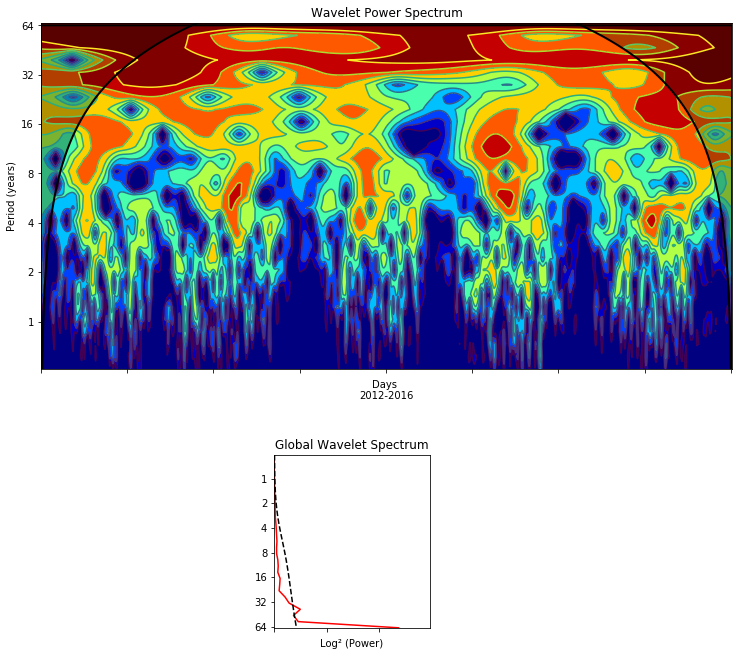

In [25]:
file = 'iig_bharati.csv'
wavelet_spectrum(file)